# Water Temperature Prediction

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os, sys, re
from time import time
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import KFold, ShuffleSplit, RepeatedKFold, train_test_split, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet

from joblib import dump, load

from permetrics.regression import RegressionMetric

# Set Variables
I'm using features_scaled here, although the random forest model doesn't actually need scaled data. It's useful for evaluating feature_importance, although since all the scaled features have pretty different distributions it's pretty hard to draw conclusions anyway.

In [2]:
model_name = "RFR1"
seed = 1993
test_size = 0.2
n_splits = 5
n_repeats = 10
proj_dir = Path('./')

hyperparameters = {
    "n_estimators": [100],
    "min_samples_split": [2, 10, 20, 30, 40, 50, 60, 70, 80],
}

features = [
    "NDVI",
    "LandTempC",
    "ClimateClass",
    "DOY",
    # "WidthMin",
    "WidthMean",
    # "WidthMax",
    # "WaterTempC",
]
features_scaled = [
    "NDVI_scaled",
    "LandTempC_scaled",
    "ClimateClass_scaled",
    "DOY_scaled",
    # "WidthMin_scaled",
    "WidthMean_scaled",
    # "WidthMax_scaled",
    # "WaterTempC_scaled",
]
y_col = "avg_temp(C)"

# Load Data

In [3]:
ml_input_data = pd.read_csv(proj_dir / 'ml_inputs_data.csv')

# shuffle the data before splitting
ml_input_data = ml_input_data.sample(frac=1).reset_index(drop=True)
ml_input_data.dropna(subset=features_scaled+[y_col,], inplace=True)

# find the latest date in the input data
latest_date = ml_input_data['Date'].max()
latest_date

'2025-10-16'

In [4]:
dev_set, test_set = train_test_split(
    ml_input_data, 
    test_size=test_size, 
    random_state=seed,
)

# add the data from the handpicked reaches to the test set
dev_set = dev_set[
    ~(
        (
            (dev_set["Name"] == "Okanogan_River_13")
            | (dev_set["Name"] == "Columbia_River_96")
            | (dev_set["Name"] == "Kootenay_River_35")
            | (dev_set["Name"] == "Willamette_River_20")
        )
        & (dev_set["Date"] > "2020-01-01")
    )
].copy()

test_set = pd.concat(
    [test_set, dev_set[
        (
            (dev_set["Name"] == "Okanogan_River_13")
            | (dev_set["Name"] == "Columbia_River_96")
            | (dev_set["Name"] == "Kootenay_River_35")
            | (dev_set["Name"] == "Willamette_River_20")
        )
        & (dev_set["Date"] > "2020-01-01")
    ]],
    
).copy()

# Training

## Cross Validation
I was worried about data leakage of the test set into the hyperparameter tuning, so I excluded the test set from this step and only worked on the train and val sets from the cross validation folds.

In [5]:
t0 = time()

cv_splitter = RepeatedKFold(
    n_splits=n_splits, 
    n_repeats=n_repeats, 
    random_state=seed,
)

list_metrics = ["RMSE", "MAE", "NSE", "R2", "KGE", "MSE"]

train_results = pd.DataFrame(columns=["parameters", "combination", "fold"] + list_metrics)
val_results = pd.DataFrame(columns=["parameters", "combination", "fold"] + list_metrics)
test_results = pd.DataFrame(columns=["parameters", "combination"] + list_metrics)
all_params = {}

for i, params in enumerate(ParameterGrid(hyperparameters)):
    print(params)
#     min_samples_split = params["min_samples_split"]
    for j, (train_idx, val_idx) in enumerate(cv_splitter.split(dev_set)):
#         if (j % 10) + 1 == 0: print(j)
        train_set = dev_set.iloc[train_idx].copy()
        val_set = dev_set.iloc[val_idx].copy()

        X_train = train_set[features_scaled]
        y_train = train_set[y_col]

        X_val = val_set[features_scaled]
        y_val = val_set[y_col]

        model = RandomForestRegressor(
            **params,
            random_state=seed,
        )
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_pred = model.predict(X_val)

        train_set["y_pred"] = y_train_pred
        val_set["y_pred"] = y_pred

        train_evaluator = RegressionMetric(list(y_train), list(y_train_pred))
        evaluator = RegressionMetric(list(y_val), list(y_pred))

        train_results = pd.concat(
            [
                train_results,
                pd.DataFrame(
                    [
                        [params, i, j]
                        + list(
                            train_evaluator.get_metrics_by_list_names(list_metrics).values()
                        )
                    ],
                    columns=["parameters", "combination", "fold"] + list_metrics,
                    index=[j],
                ),
            ]
        )

        val_results = pd.concat(
            [
                val_results,
                pd.DataFrame(
                    [
                        [params, i, j]
                        + list(
                            evaluator.get_metrics_by_list_names(list_metrics).values()
                        )
                    ],
                    columns=["parameters", "combination", "fold"] + list_metrics,
                    index=[j],
                ),
            ]
        )
    all_params[i] = model.get_params()

train_results['min_samples_split'] = train_results['parameters'].apply(lambda x: x['min_samples_split'])
train_results.to_csv(f"{model_name}_train_results.csv", index=False)

val_results['min_samples_split'] = val_results['parameters'].apply(lambda x: x['min_samples_split'])
val_results.to_csv(f"{model_name}_val_results.csv", index=False)

print(f'Training complete in {(time()-t0)/60.:.1f} minutes')

{'min_samples_split': 2, 'n_estimators': 100}
{'min_samples_split': 10, 'n_estimators': 100}
{'min_samples_split': 20, 'n_estimators': 100}
{'min_samples_split': 30, 'n_estimators': 100}
{'min_samples_split': 40, 'n_estimators': 100}
{'min_samples_split': 50, 'n_estimators': 100}
{'min_samples_split': 60, 'n_estimators': 100}
{'min_samples_split': 70, 'n_estimators': 100}
{'min_samples_split': 80, 'n_estimators': 100}
Training complete in 21.1 minutes


In [6]:
results = pd.merge(train_results.reset_index().loc[:,['combination', 'fold', 'min_samples_split', 'RMSE']], val_results.reset_index().loc[:,['RMSE']], left_index=True, right_index=True, suffixes=('_train', '_val'))
results['RMSE_diff'] = results['RMSE_val'] - results['RMSE_train']
# results['R2_diff'] = -1 * (results['R2_val'] - results['R2_train'])
results.round(3)

,combination,fold,min_samples_split,RMSE_train,RMSE_val,RMSE_diff
0,0,0,2,0.398,1.004,0.606
1,0,1,2,0.402,0.987,0.584
2,0,2,2,0.404,0.976,0.571
3,0,3,2,0.387,1.013,0.626
4,0,4,2,0.409,0.858,0.449
...,...,...,...,...,...,...
445,8,45,80,1.126,1.188,0.062
446,8,46,80,1.104,1.268,0.163
447,8,47,80,1.115,1.220,0.104
448,8,48,80,1.129,1.191,0.063


## Finding best hyperparameters
Quality score is RMSE_val plus RMSE_diff, and I'll first sort by the quality score then by the RMSE_val score. I round the quality score to the nearest 0.1 degree so small val - train gap differences don't overwhelm improvements in val score.

In [27]:
print('mean RMSE')
mean_results = results.groupby('min_samples_split').mean()[['RMSE_train', 'RMSE_val', 'RMSE_diff']].round(3)
mean_results['RMSE_qual'] = mean_results['RMSE_val'] + mean_results['RMSE_diff']
mean_results['RMSE_qual'] = mean_results['RMSE_qual'].round(1)
mean_results

mean RMSE


,RMSE_train,RMSE_val,RMSE_diff,RMSE_qual
min_samples_split,,,,
2,0.400,0.969,0.569,1.5
10,0.644,1.012,0.368,1.4
20,0.817,1.070,0.254,1.3
30,0.919,1.117,0.197,1.3
40,0.991,1.153,0.162,1.3
50,1.034,1.172,0.138,1.3
60,1.071,1.188,0.118,1.3
70,1.098,1.202,0.104,1.3
80,1.120,1.214,0.094,1.3


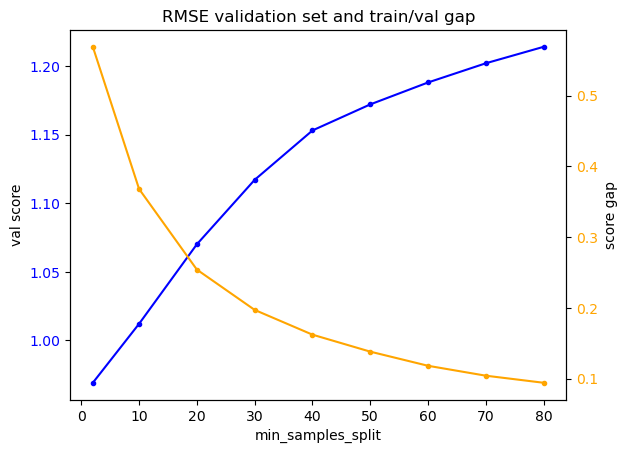

In [28]:
fig, ax1 = plt.subplots()
ax1.set_title('RMSE validation set and train/val gap')
ax1.plot(mean_results['RMSE_val'], marker='.', c='b')
ax1.set_xlabel('min_samples_split')
ax1.set_ylabel('val score')
ax1.tick_params(axis='y', labelcolor='b')
ax2 = ax1.twinx()
ax2.plot(mean_results['RMSE_diff'], marker='.', c='orange')
ax2.set_ylabel('score gap')
ax2.tick_params(axis='y', labelcolor='orange')
plt.show()

In [9]:
print('Best hyperparameter value')
best = mean_results.sort_values(by=['RMSE_qual', 'RMSE_val'], ascending=True).head(1)
best_min_samples = best.index[0]
best

Best hyperparameter value


,RMSE_train,RMSE_val,RMSE_diff,RMSE_qual
min_samples_split,,,,
20,0.817,1.07,0.254,1.3


Checking the variability of the CV scores here - the val sets are much smaller than the train sets so their scores being more variable is to be expected.

In [10]:
print('average standard deviation')
stdv_results = results.groupby('min_samples_split').std()[['RMSE_train', 'RMSE_val', 'RMSE_diff']]
stdv_train = stdv_results.mean()['RMSE_train']
stdv_val = stdv_results.mean()['RMSE_val']
stdv_diff = stdv_results.mean()['RMSE_diff']
print(f'train: {stdv_train:.3f}\n  val: {stdv_val:.3f}\n diff: {stdv_diff:.3f}')
# stdv_results.round(3)

average standard deviation
train: 0.009
  val: 0.038
 diff: 0.046


## Model Fit
Now it's time to fit to the full dev set and predict on the test set.

In [11]:
final_model = RandomForestRegressor(
    n_estimators=all_params[0]['n_estimators'],
    min_samples_split=best_min_samples,
)
final_model.fit(dev_set[features_scaled], dev_set[y_col])

y_dev_pred = final_model.predict(dev_set[features_scaled])
y_pred = final_model.predict(test_set[features_scaled])
test_set["y_pred"] = y_pred
test_set.to_csv(f"{model_name}_test_set.csv", index=False)

In [12]:
final_params = final_model.get_params()
n_estimators = final_params['n_estimators']
min_samples_split = final_params['min_samples_split']

y_dev = dev_set[y_col]
y_test = test_set[y_col]
dev_evaluator = RegressionMetric(list(y_dev), list(y_dev_pred))
evaluator = RegressionMetric(list(y_test), list(y_pred))
dev_results = pd.Series(dev_evaluator.get_metrics_by_list_names(list_metrics))
test_results = pd.Series(evaluator.get_metrics_by_list_names(list_metrics))
final_results = pd.DataFrame(columns=['dev', 'test'])
final_results['dev'] = dev_results
final_results['test'] = test_results
final_results['diff'] = final_results['test'] -  final_results['dev']
final_results.to_csv(f"{model_name}_final_results.csv", index=False)
results_reshape = pd.melt(
    final_results.reset_index().rename(columns={'index':'metric'}), 
    id_vars='metric', 
    value_vars=['dev', 'test'],
    var_name='set',
    value_name='value',
)
final_results.round(2)

,dev,test,diff
RMSE,0.78,1.05,0.27
MAE,0.56,0.74,0.18
NSE,0.98,0.97,-0.02
R2,0.98,0.97,-0.02
KGE,0.98,0.98,-0.00
MSE,0.62,1.10,0.49


# Results

['NDVI', 'LandTempC', 'ClimateClass', 'DOY', 'WidthMean']
[0.00981 0.00864 0.00714 0.96301 0.0114 ]


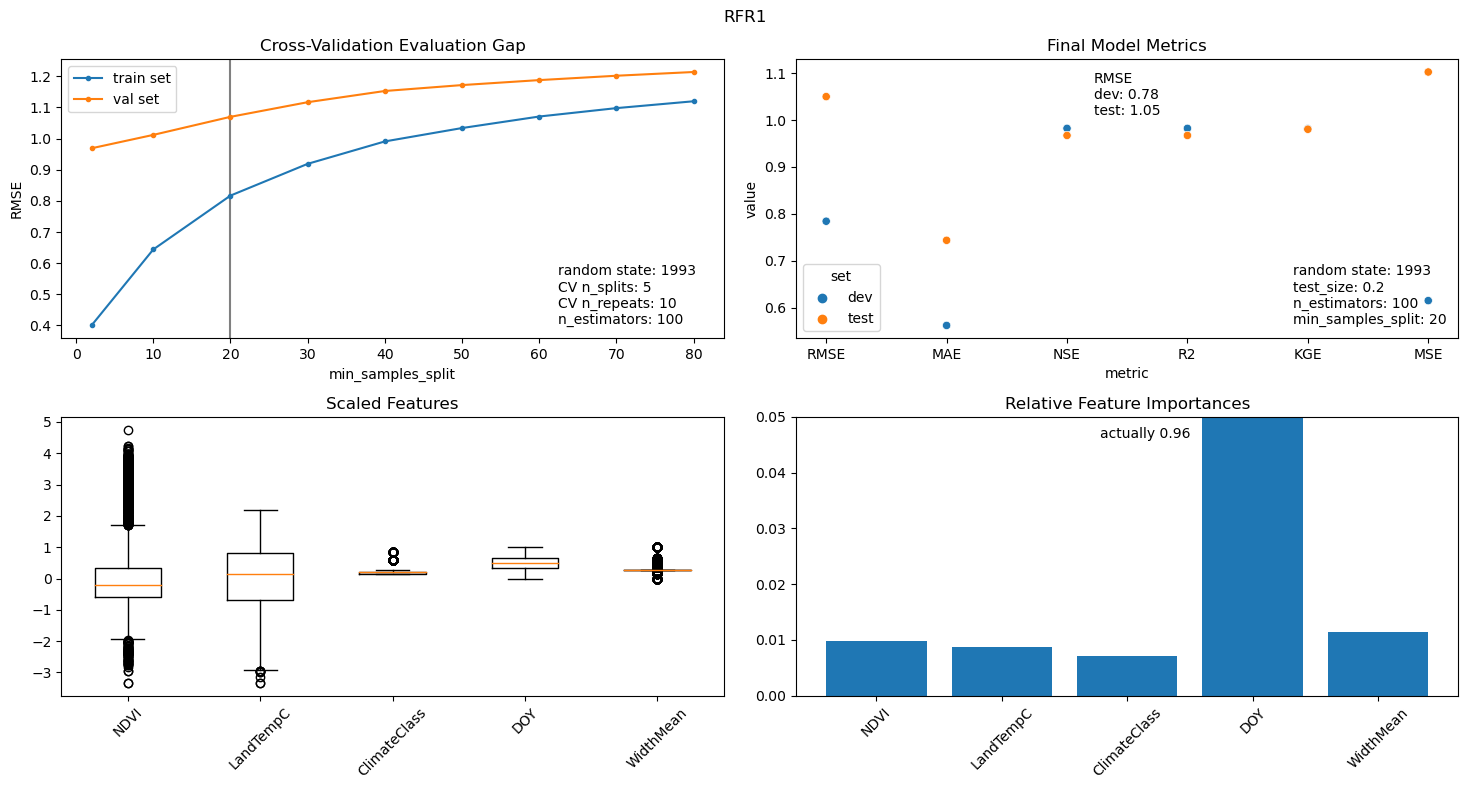

In [13]:
CV_text = f"""random state: {seed}
CV n_splits: {n_splits}
CV n_repeats: {n_repeats}
n_estimators: {n_estimators}"""
final_text = f"""random state: {seed}
test_size: {test_size}
n_estimators: {n_estimators}
min_samples_split: {min_samples_split}"""
err_text = f"""RMSE
dev: {final_results.at['RMSE', 'dev']:.2f}
test: {final_results.at['RMSE', 'test']:.2f}"""
plt.figure(figsize=(15,8))
plt.suptitle(f'{model_name}')
plt.subplot(221)
plt.axvline(best_min_samples, c='gray')
plt.plot(mean_results['RMSE_train'], marker='.', label='train set')
plt.plot(mean_results['RMSE_val'], marker='.', label='val set')
plt.annotate(CV_text, (0.75,0.05), xycoords='axes fraction')
plt.ylabel('RMSE')
plt.xlabel('min_samples_split')
plt.legend()
plt.title('Cross-Validation Evaluation Gap')
plt.subplot(222)
sns.scatterplot(data=results_reshape, x='metric', y='value', hue='set')
plt.annotate(final_text, (0.75, 0.05), xycoords='axes fraction')
plt.annotate(err_text, (0.45, 0.8), xycoords='axes fraction')
plt.title('Final Model Metrics')
plt.subplot(223)
spreads = dev_set[features_scaled]
plt.boxplot(spreads)
plt.xticks(np.arange(1, len(features)+1), features, rotation=45)
plt.title('Scaled Features')
plt.subplot(224)
cats = features
vals = np.round(final_model.feature_importances_, 5)
plt.bar(cats, vals)
maxy = 0.05
idx_doy = features_scaled.index('DOY_scaled')
plt.ylim(0,maxy)
plt.annotate(f'actually {vals[idx_doy]:.2f}', (cats[idx_doy], maxy), xytext=(-110, -15), textcoords='offset points')
plt.xticks(rotation=45)
plt.title('Relative Feature Importances')
print(cats)
print(vals)
plt.tight_layout()
plt.savefig(f'{model_name}_results.png')
plt.show()

# Save tree dot data to make images

In [30]:
from sklearn import tree

colors = {'NDVI': '#00a86b', 'LandTempC': '#e34234', 'ClimateClass': '#0064c8', 'DOY': '#800080', 'WidthMean': '#996666'}

tree_dot_dir = f'tree_dots/n{n_estimators}s{min_samples_split}'
Path(tree_dot_dir).mkdir(exist_ok=True)

nwrite = 0
for tree_num in range(n_estimators):
    dot_data = tree.export_graphviz(
        final_model.estimators_[tree_num], 
        out_file=None, 
        feature_names=features, 
        filled=True, 
        rounded=True, 
        special_characters=True,
    )

    fn = f'{tree_dot_dir}/in_tree_dot.txt'
    with open(fn, 'w') as f:
        f.write(dot_data)
    with open(fn, 'r') as f:
        lines = f.readlines()
    fn = f'{tree_dot_dir}/tree_dot_{tree_num}.txt'
    with open(fn, 'w') as f:
        for line in lines:
            if 'digraph' in line:
                f.write(line)
            elif 'node [shape=box' in line:
                new_line = re.sub(r'fontname="helvetica"\]', 'fontname="arial"]', line)
                f.write(new_line)
            elif 'edge [fontname=' in line:
                new_line = re.sub(r'fontname="helvetica"\]', 'fontname="arial", color="#aaaaaa"]', line)
                f.write(new_line)
            elif "->" not in line and "[" in line and "]" in line:
                if '[label=<squared_error' in line:
                    new_line = re.sub(r'fillcolor="#\w*"', 'fillcolor="#aaaaaa"', line)
                    f.write(new_line)
                else:
                    node_label_match = re.findall(r'label=<(\w+) ', line)
                    node_label = node_label_match[0]
                    fill_color = colors[node_label]
                    new_line = re.sub(r'fillcolor="#\w*"', f'fillcolor="{fill_color}"', line)
                    f.write(new_line)
            else:
                f.write(line)
    nwrite+=1
print(f'{nwrite} files written successfully')

100 files written successfully


# Afterwards

After this point, fit to entire data set to use on database

In [ ]:
## test_results["delta_MSE"] = np.abs(test_results["MSE"] - test_results["MSE"].shift(1))

# # find the set of hyperparameters with a patience of 5 for delta MSE at 0.005
# patience = 5
# delta = 0.005

# test_results["patience"] = test_results["delta_MSE"].apply(lambda x: 1 if x < delta else 0)
# test_results["patience"] = test_results["patience"] + test_results["patience"].shift(-1) + test_results["patience"].shift(-2) + test_results["patience"].shift(-3) + test_results["patience"].shift(-4)

# # get the first hyperparameters with the patience of 5
# best_hyperparameters = test_results[test_results["patience"] == patience].iloc[0]["parameters"]
# # save the best hyperparameters
# with open(f"{model_name}_params.json", "w") as f:
#             json.dump(best_hyperparameters, f)

In [ ]:
# # final_model = RandomForestRegressor(n_estimators=best_hyperparameters["n_estimators"], random_state=seed)
# final_model = RandomForestRegressor(n_estimators=100)
# final_model.fit(dev_set[features], dev_set[y_col])

# test_set["y_pred"] = final_model.predict(test_set[features])
# test_set.to_csv(f"{model_name}_test_set.csv", index=False)

In [ ]:
# # boxplot and mean line of the dev results for each parameter
# fig, ax = plt.subplots(1,2, figsize=(12, 6))
# dev_results.boxplot(column='MSE', by='n_estimators', ax=ax[1])
# dev_results.groupby('n_estimators').mean(numeric_only=True).plot(y='MSE', ax=ax[0], color='black', marker='o')
# ax[0].axvline(x=best_hyperparameters['n_estimators'], color='red', linestyle='--', label='No. of Trees = 100')
# ax[0].legend()
# # ax[0].set_title('Mean MSE for different number of estimators')
# ax[0].set_title('a)')
# # ax[1].set_title('Distribution of MSE for different number of estimators')
# ax[1].set_title('b)')
# ax[0].set_xlabel('Number of Trees')
# ax[0].set_ylabel('Mean Squared Error')
# ax[1].set_xlabel('Number of Trees')
# ax[1].set_ylabel('Mean Squared Error')
# fig.suptitle('')
# fig.tight_layout()

In [ ]:
# # scatter plot of the test results
# fig, ax = plt.subplots(1,1, figsize=(5, 5))
# test_set.plot.scatter(x='avg_temp(C)', y='y_pred', ax=ax, s=.75)
# ax.plot([0, 30], [0, 30], color='k', linestyle='--')
# ax.set_xlabel('In-situ Water Temperature (C)')
# ax.set_ylabel('Estimated Water Temperature (C)')
# ax.set_title('Random Forest Regression')

# mae, mse, rmse, r2, nse, kge = test_results[test_results["patience"] == patience].iloc[0][['MAE', 'MSE', 'RMSE', 'R2', 'NSE', 'KGE']]

# ax.annotate(f'MAE: {mae:.2f}', xy=(0.05, 0.9), xycoords='axes fraction')
# ax.annotate(f'MSE: {mse:.2f}', xy=(0.05, 0.85), xycoords='axes fraction')
# ax.annotate(f'RMSE: {rmse:.2f}', xy=(0.05, 0.8), xycoords='axes fraction')
# ax.annotate(f'R2: {r2:.2f}', xy=(0.05, 0.75), xycoords='axes fraction')
# ax.annotate(f'NSE: {nse:.2f}', xy=(0.05, 0.7), xycoords='axes fraction')
# ax.annotate(f'KGE: {kge:.2f}', xy=(0.05, 0.65), xycoords='axes fraction')

In [ ]:
# # train the model with the best hyperparameters on all the data and save it
# final_model = RandomForestRegressor(n_estimators=best_hyperparameters["n_estimators"], random_state=seed)

# X = ml_input_data[features]
# y = ml_input_data[y_col]

# final_model.fit(X, y)

# dump(final_model, f"{model_name}.joblib")

Test set stuff from cross validation

In [ ]:

#     X_dev = dev_set[features_scaled]
#     y_dev = dev_set[y_col]

#     X_test = test_set[features_scaled]
#     y_test = test_set[y_col]

#     model = RandomForestRegressor(min_samples_split=min_samples_split, random_state=seed)
#     model.fit(X_dev, y_dev)

#     y_pred = model.predict(X_test)

#     test_set["y_pred"] = y_pred

#     mse = mean_squared_error(y_test, y_pred)
#     rmse = np.sqrt(mse)
#     r2 = r2_score(y_test, y_pred)
#     # nse = 1 - mse / np.var(y_val)
#     mae = np.mean(np.abs(y_test - y_pred))

#     evaluator = RegressionMetric(list(y_test), list(y_pred))

#     test_results = pd.concat(
#         [
#             test_results,
#             pd.DataFrame(
#                 [
#                     [params, i]
#                     + list(evaluator.get_metrics_by_list_names(list_metrics).values())
#                 ],
#                 columns=["parameters", "combination"] + list_metrics,
#                 index=[i],
#             ),
#         ]
#     )

# test_results['min_samples_split'] = test_results['parameters'].apply(lambda x: x['min_samples_split'])
# test_results.to_csv(f"{model_name}_test_results.csv", index=False)
